In [1]:
from dask.distributed import Client, SSHCluster
import sys
import dask
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import dask.dataframe as dd
import dask.array as da
import dask.bag as db
import matplotlib.pyplot as plt

from dask import delayed
from time import time, sleep

## DASK CLUSTER

In [140]:
n_workers_vm = 2
n_threads_wk = 2
n_workers = 4*n_workers_vm

cluster = SSHCluster(
    ["10.67.22.39", "10.67.22.74", "10.67.22.27", "10.67.22.91", "10.67.22.60"],
    connect_options   = {"known_hosts": "/root/.ssh/known_hosts"},
    worker_options    = {"nthreads": n_threads_wk, "n_workers": n_workers_vm},
    scheduler_options = {"dashboard_address": ":8787"}
)


2022-07-09 16:43:04,737 - distributed.deploy.ssh - INFO - 2022-07-09 16:43:04,736 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2022-07-09 16:43:04,797 - distributed.deploy.ssh - INFO - 2022-07-09 16:43:04,796 - distributed.scheduler - INFO - State start
2022-07-09 16:43:04,801 - distributed.deploy.ssh - INFO - 2022-07-09 16:43:04,800 - distributed.scheduler - INFO - Clear task state
2022-07-09 16:43:04,803 - distributed.deploy.ssh - INFO - 2022-07-09 16:43:04,801 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.39:44619
2022-07-09 16:43:07,051 - distributed.deploy.ssh - INFO - 2022-07-09 16:43:07,037 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.74:34089'
2022-07-09 16:43:07,059 - distributed.deploy.ssh - INFO - 2022-07-09 16:43:07,046 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.74:34291'
2022-07-09 16:43:07,433

In [141]:
client = Client(cluster)
client

<Client: 'tcp://10.67.22.39:44619' processes=8 threads=16, memory=31.08 GiB>

## Functions

In [4]:
def load(path):
    return np.load(path, allow_pickle=True)["a"]

def R_yz(theta_rot, phi_rot):
    return np.array([[np.cos(phi_rot) * np.cos(theta_rot), -np.sin(phi_rot) * np.cos(theta_rot), np.sin(theta_rot)], 
                     [np.sin(phi_rot), np.cos(phi_rot), 0], 
                     [-np.sin(theta_rot) * np.cos(phi_rot), np.sin(theta_rot) * np.sin(phi_rot), np.cos(theta_rot)]])

def convert_pmt_ids(input_ids, conversion_ids):
    cd_ids  = np.array(conversion_ids["CdID"])
    pmt_ids = np.array(conversion_ids["PMTID"])
    mask    = np.isin(cd_ids, input_ids)
    return pmt_ids[mask]

def find_pmt_coord(pmt_positions, data_pmt_id):
    return pmt_positions[
        np.isin(pmt_positions.PMTID, data_pmt_id)
        ].loc[:, ['x', 'y', 'z']].reset_index(drop=True).to_numpy()

## Load mapping data

In [127]:
data_folder       = "/root/data/data/real/train/data/"
pmt_pos_fname     = "PMTPos_CD_LPMT.csv"
pmt_id_conv_fname = "PMT_ID_conversion.csv"
train_data_fname  = "raw_data_train_4.npz"

# test multiple files
nfiles = 20
name_list = glob.glob('*.npz', root_dir=data_folder)[:nfiles]

In [6]:
pmt_positions     = pd.read_csv(pmt_pos_fname)
pmt_id_conversion = pd.read_csv(pmt_id_conv_fname)
conversion_ids    = pd.read_csv(pmt_id_conv_fname)

## Distributed Processing - rotation distributed by event

In [7]:
def load_bag(path, Nevents):
    data_np = load(path)
    data_np = data_np[:, :Nevents]
    return [np.vstack([ data_np[j, i] for j in range(3)]) for i in range(data_np.shape[1])]

In [108]:
def rotate_ev(data):

    nonzeros_inds = data[2] != 0.0
    data_pmt_id   = convert_pmt_ids(data[0][nonzeros_inds], conversion_ids)
    pmt_coord     = find_pmt_coord(pmt_positions, data_pmt_id)

    tot_charge = sum(data[1][nonzeros_inds])
    x_cc       = sum(pmt_coord[:,0] * data[1][nonzeros_inds]) / tot_charge
    y_cc       = sum(pmt_coord[:,1] * data[1][nonzeros_inds]) / tot_charge
    z_cc       = sum(pmt_coord[:,2] * data[1][nonzeros_inds]) / tot_charge

    theta_cc   = np.arctan2(
        np.sqrt((x_cc)**2+(y_cc)**2), z_cc
    )
    phi_cc     = np.arctan2(y_cc, x_cc) 

    theta_rot = -theta_cc + np.pi/2
    phi_rot   = -phi_cc
    
    # coord_new = np.matmul(R_yz(theta_rot, phi_rot), pmt_coord.T)
    coord_new = np.matmul(
        R_yz(theta_rot, phi_rot), pmt_coord.T
    )

    R = np.sqrt(np.sum(np.power(coord_new, 2), axis=0))

    charge_hitt = np.vstack([data[1], data[2]])
    charge_hitt = charge_hitt[:,nonzeros_inds]

    rotated = np.vstack([coord_new, R, charge_hitt])
    
    del coord_new
    del charge_hitt
    del pmt_coord
    del data_pmt_id
    del nonzeros_inds
    
    return rotated

In [10]:
Nevents = None
start = time()

#data_db = db.map(load_bag, name_list, Nevents=None)
#data_db = data_db.flatten().repartition(npartitions=16)

data_db = db.from_sequence(load_bag(data_folder + train_data_fname, Nevents=None), npartitions=16)
stop = time()

print('Execution time:', stop-start)
data_db

Execution time: 9.026978492736816


dask.bag<from_sequence, npartitions=16>

In [10]:
data_db.take(1)

(array([[2.68435456e+08, 2.68435712e+08, 2.68435968e+08, ...,
         2.72942592e+08, 2.72943104e+08, 2.72943872e+08],
        [1.01690963e+00, 1.28989536e+00, 1.45731761e+00, ...,
         8.40746671e-01, 6.20022943e-01, 5.43713687e-01],
        [2.78543843e+02, 2.70036129e+02, 2.63317109e+02, ...,
         2.72593537e+02, 2.43800823e+02, 4.18888109e+02]]),)

Execution time: 0.02822399139404297


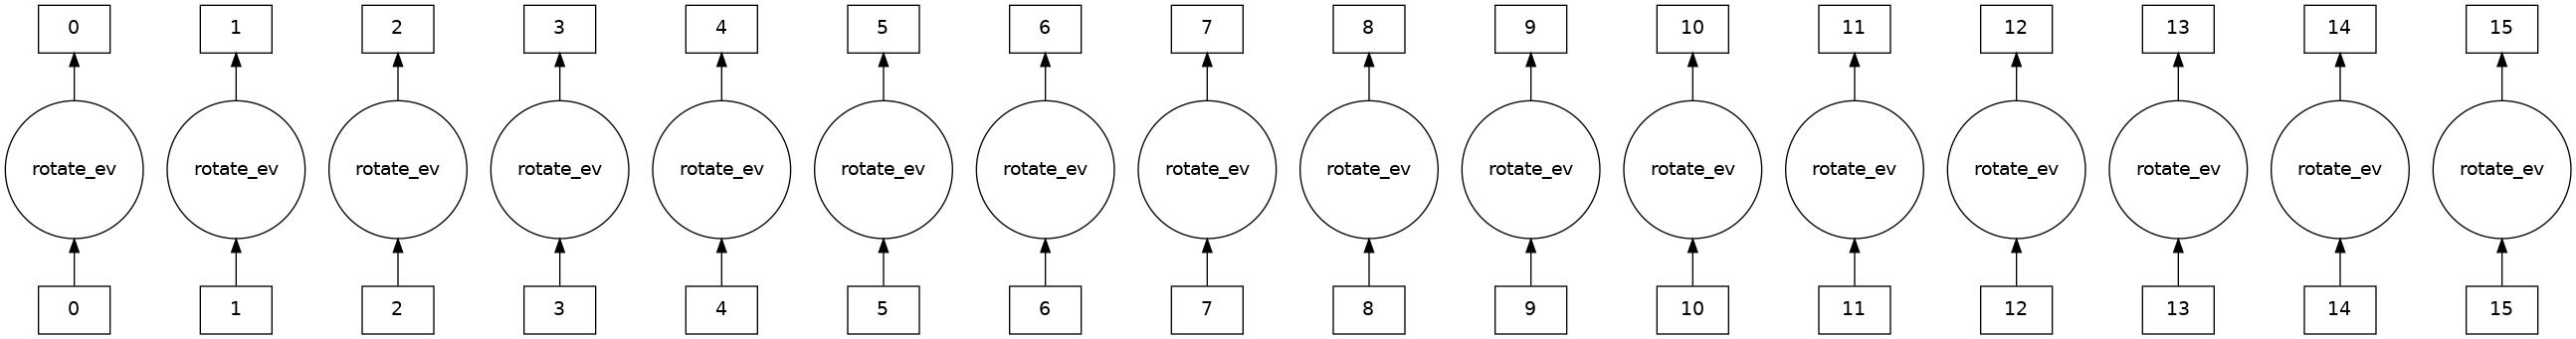

In [11]:
start = time()
rotated = db.map(rotate_ev, data_db)
stop = time()

print('Execution time:', stop-start)

rotated.visualize()

#### Plot the rotated event

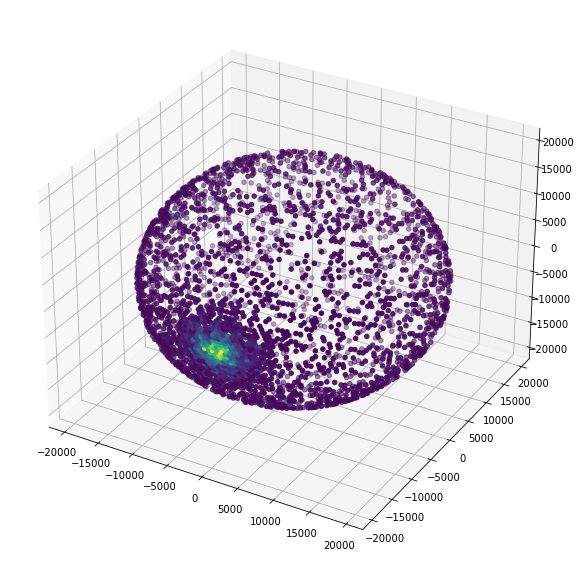

In [54]:
ev = 4
rot = rotated.take(ev+1)[ev]

fig = plt.figure(figsize=(10,12))
axr = fig.add_subplot(111, projection='3d')

axr.scatter(
    xs = rot[1, :],
    ys = -rot[0, :],
    zs = rot[2, :],
    c  = rot[4, :]
    )

## Distributed Processing - 2D mapping distributed by event

In [9]:
N_max = 115

def mapping_single_event(rotated_ev):
    ####################
    # rotated_ev must be computed
    ####################
    coord_new   = rotated_ev[:3]
    charge_hitt = rotated_ev[4:, ].T
    R           = rotated_ev[3, ].mean()
    del rotated_ev

    z_levels, step = np.linspace(coord_new[2,].min(), coord_new[2,].max(), 124, retstep=True)
    #z_levels       = z_levels.persist()
    image_mat      = np.zeros((230,124,2))

    #masks = 

    for j, z in enumerate(z_levels):
        mask = (np.abs(coord_new[2,] - z) < step/2)         #(np.abs(pmt_pos.z - z) < delta)
        if(not np.any(mask)): continue
        masked = coord_new[:,mask]


        Rz = (R**2 - z**2)
        Neff = 0 if Rz < 0 else N_max * np.sqrt(Rz) / R
        #ix = np.zeros(np.sum(mask), dtype=np.int32)
        ix = np.around( Neff * (np.arctan2(masked[1,], masked[0,]) / np.pi) + (N_max / 2) ) + 57
        ix = ix.astype(np.int32)
        #ix = ix.compute()
        if(np.any(ix >= 230)):
            ix[ix >= 230] = ix[ix >= 230] - 230

        image_mat[ix, j,] = charge_hitt[mask, ]

        del ix
        del masked
        del mask
                

    del z_levels
    del coord_new
    del charge_hitt
    
    return image_mat

Execution time: 0.0019006729125976562


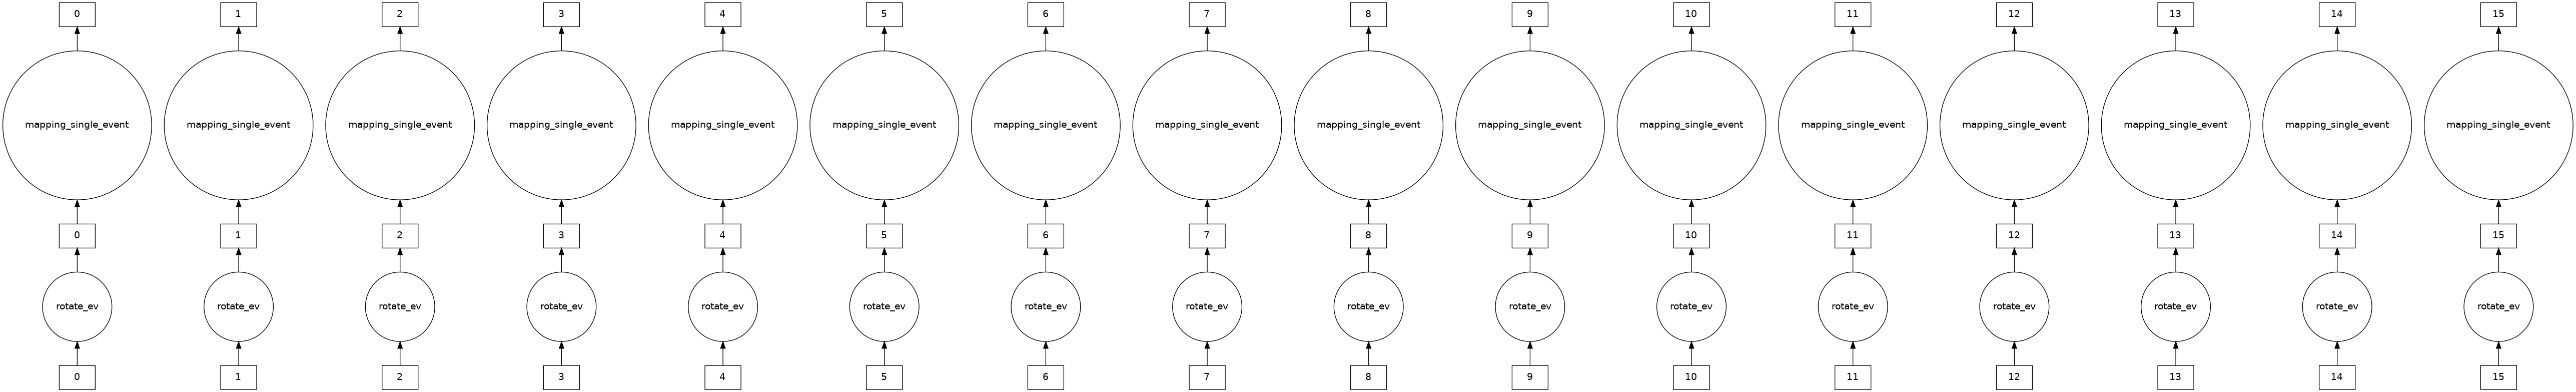

In [12]:
start = time()
mapped = db.map(mapping_single_event, rotated)
stop = time()

print('Execution time:', stop-start)
mapped.visualize()

In [13]:
start = time()
images = mapped.compute()
stop = time()

print('Execution time:', stop-start)

: 

: 

### Plot mapped event

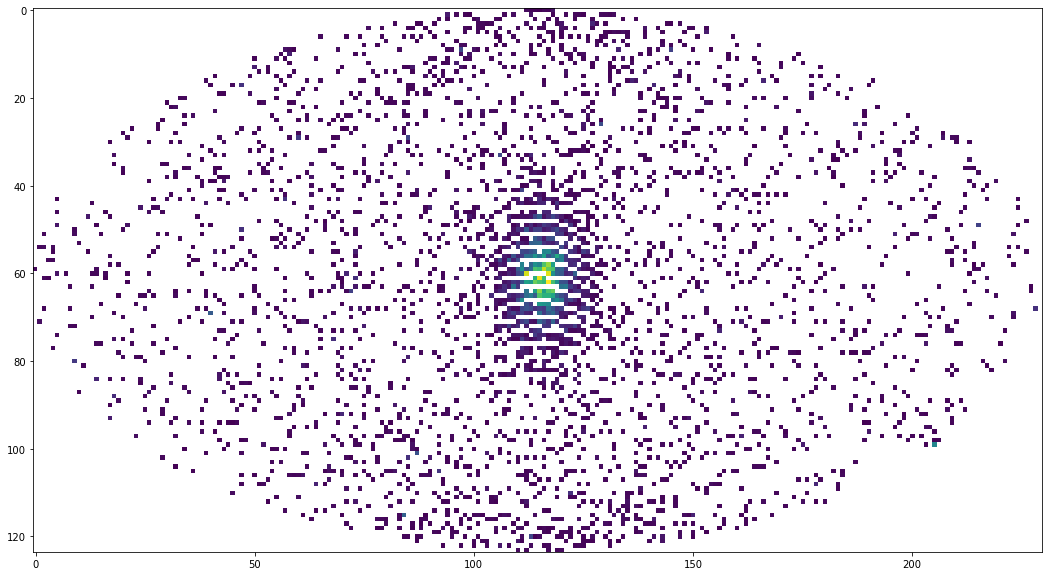

In [58]:
ev = 4

image = images[ev][:,:,0].T
image[image == 0] = np.NaN

fig, ax = plt.subplots(1, figsize=(20,10))
ax.imshow(image)
plt.show()

In [15]:
array = da.stack(mapped)

In [17]:
array

## Compute over files

In [10]:
def load(path):
    file = np.load(path, allow_pickle=True)
    data = file['a']
    del file.f
    file.close()
    del file
    return data

In [101]:
def save_partition(chunk, filename):
    array = np.stack(chunk)
    np.save(filename[0], array, allow_pickle=False)
    length = len(array)
    del array
    del chunk
    return length

In [12]:
def stack_partition(chunk):
    result = np.stack(chunk)
    del chunk
    return result
    

In [100]:
def save_array(array, filename):
    np.save(filename[0], array, allow_pickle=False)
    length = len(array)
    del array
    return length

In [21]:
granular = True

#lazy_loaded = [dask.delayed(load_bag)(data_folder + file_name, Nevents=None) for file_name in name_list]

for file_name in name_list:
  
    # load one file
    data_db = db.from_sequence(load_bag(data_folder + file_name, Nevents=None), npartitions=n_workers)
    
    # save #npartitions processed files for each raw data file
    ofilenames = db.from_sequence(['/root/data/test/proj_' + file_name.split('.')[0] + '.part' + str(i) for i in range(n_workers)], npartitions=n_workers)
    #ofilenames = db.from_sequence(['/root/data/test/proj_' + name_list[i].split('.')[0]])

    rotated = db.map(rotate_ev, data_db)

    mapped = db.map(mapping_single_event, rotated)

    if granular:
        array = db.map_partitions(stack_partition, mapped)
        save = db.map_partitions(save_array, array, ofilenames)
        del array
    else:
        save = db.map_partitions(save_partition, mapped, ofilenames)
    

    save.compute()

    # free RAM: have to delete all futures
    del mapped
    del rotated
    del data_db
    del ofilenames

In [29]:
data_db

dask.bag<bag-from-delayed, npartitions=1>

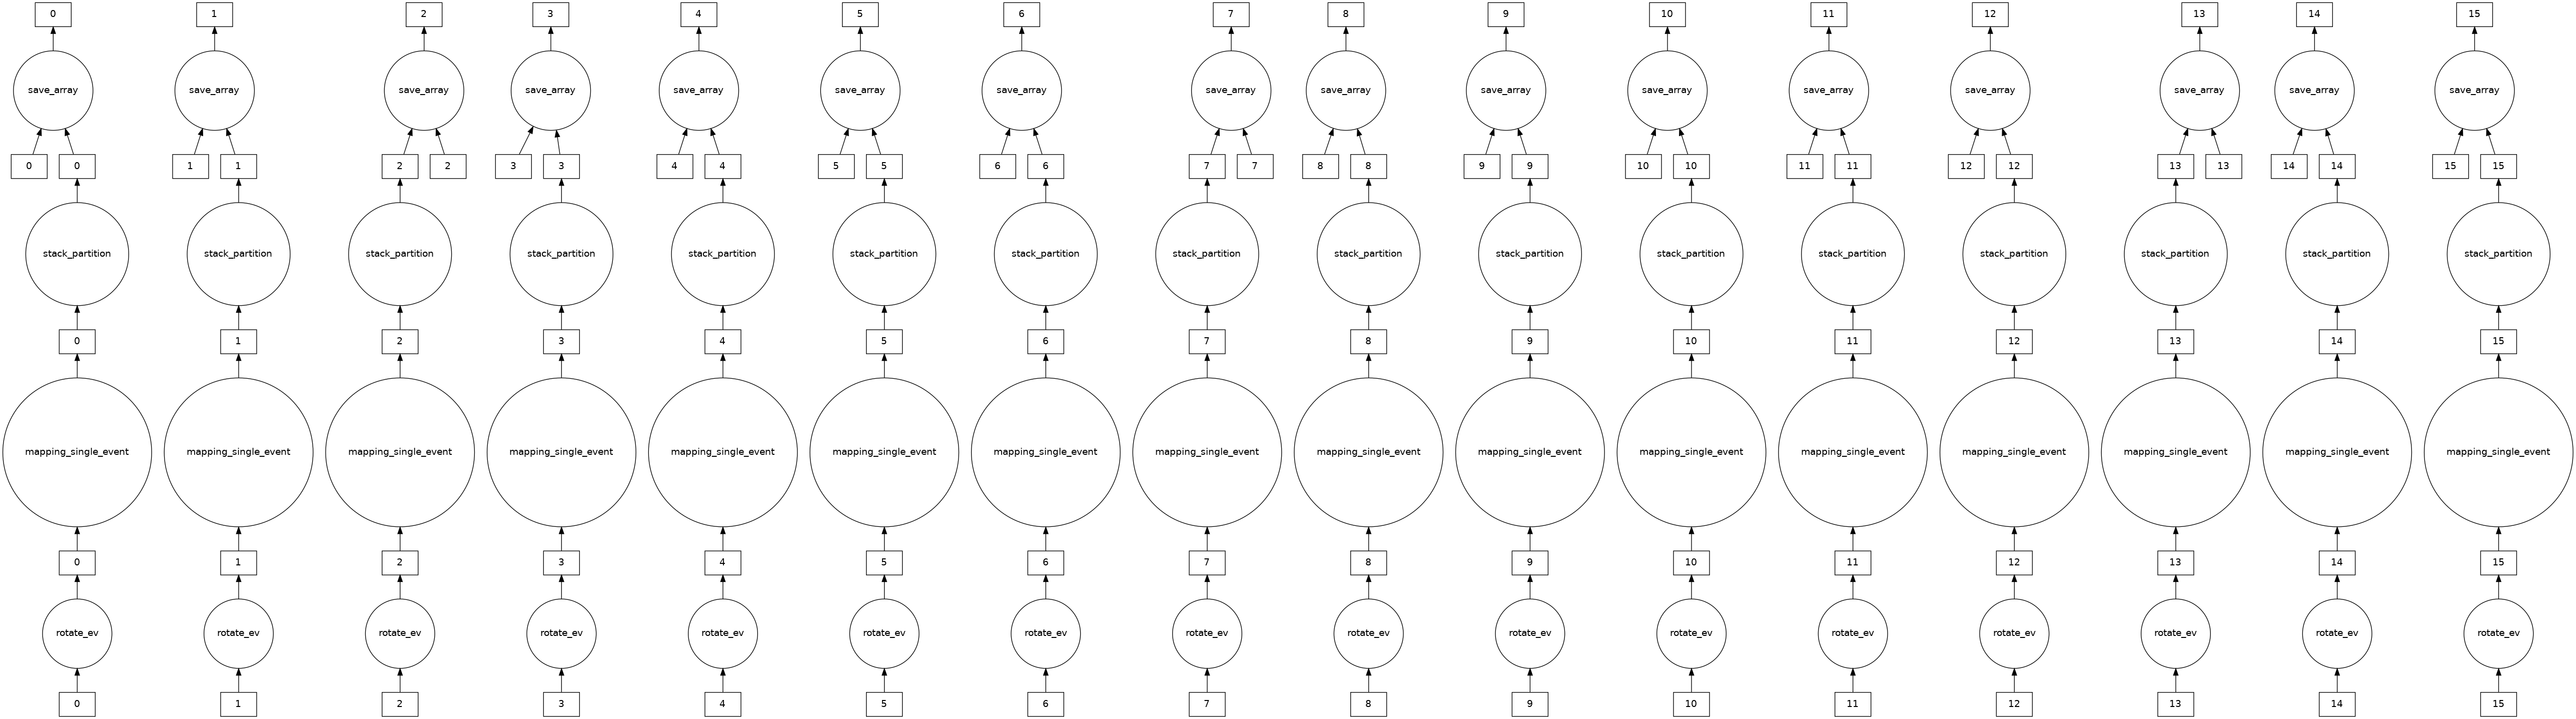

In [14]:
save.visualize()

## Compute over files - distributed version

In [14]:
def load_bag(path, Nevents):
    data_np = load(path)
    data_mask = data_np[:, :Nevents]
    bag = [np.vstack([ data_mask[j, i] for j in range(3)]) for i in range(data_mask.shape[1])]
    del data_mask
    del data_np
    return bag 
lazy_load_bag = dask.delayed(load_bag)

In [142]:
granular     = False
nfiles_cycle = 2
compute_times = []
restart_times = []
for i in range(0, nfiles, nfiles_cycle):

    lazy_loaded = db.from_delayed([lazy_load_bag(data_folder + file_name, None) for file_name in name_list[i:i+nfiles_cycle]]).repartition(n_workers_vm*n_threads_wk*4)
    ofilenames = db.from_sequence(['/root/data/test/proj_' + name_list[k].split('.')[0] + '.part' + str(j) 
                                    for j in range(int(n_workers_vm*n_threads_wk*4/nfiles_cycle)) 
                                    for k in range(i, i+nfiles_cycle)])

    rotated = db.map(rotate_ev, lazy_loaded)
    mapped = db.map(mapping_single_event, rotated)

    del rotated
    if granular:
        array = db.map_partitions(stack_partition, mapped)
        del mapped

        save = db.map_partitions(save_array, array, ofilenames)
        del array
    else:
        save = db.map_partitions(save_partition, mapped, ofilenames)
        
        del mapped
        
    del lazy_loaded
    del ofilenames
    
    start = time()
    future = client.compute(save, optimize_graph=False)
    result = client.gather(future)
    stop = time()
    compute_times.append(stop-start)
    
    start = time()
    client.restart()
    stop = time()
    restart_times.append(stop-start)

compute_times = np.asarray(compute_times)
restart_times = np.asarray(restart_times)

ValueError: zero-dimensional arrays cannot be concatenated

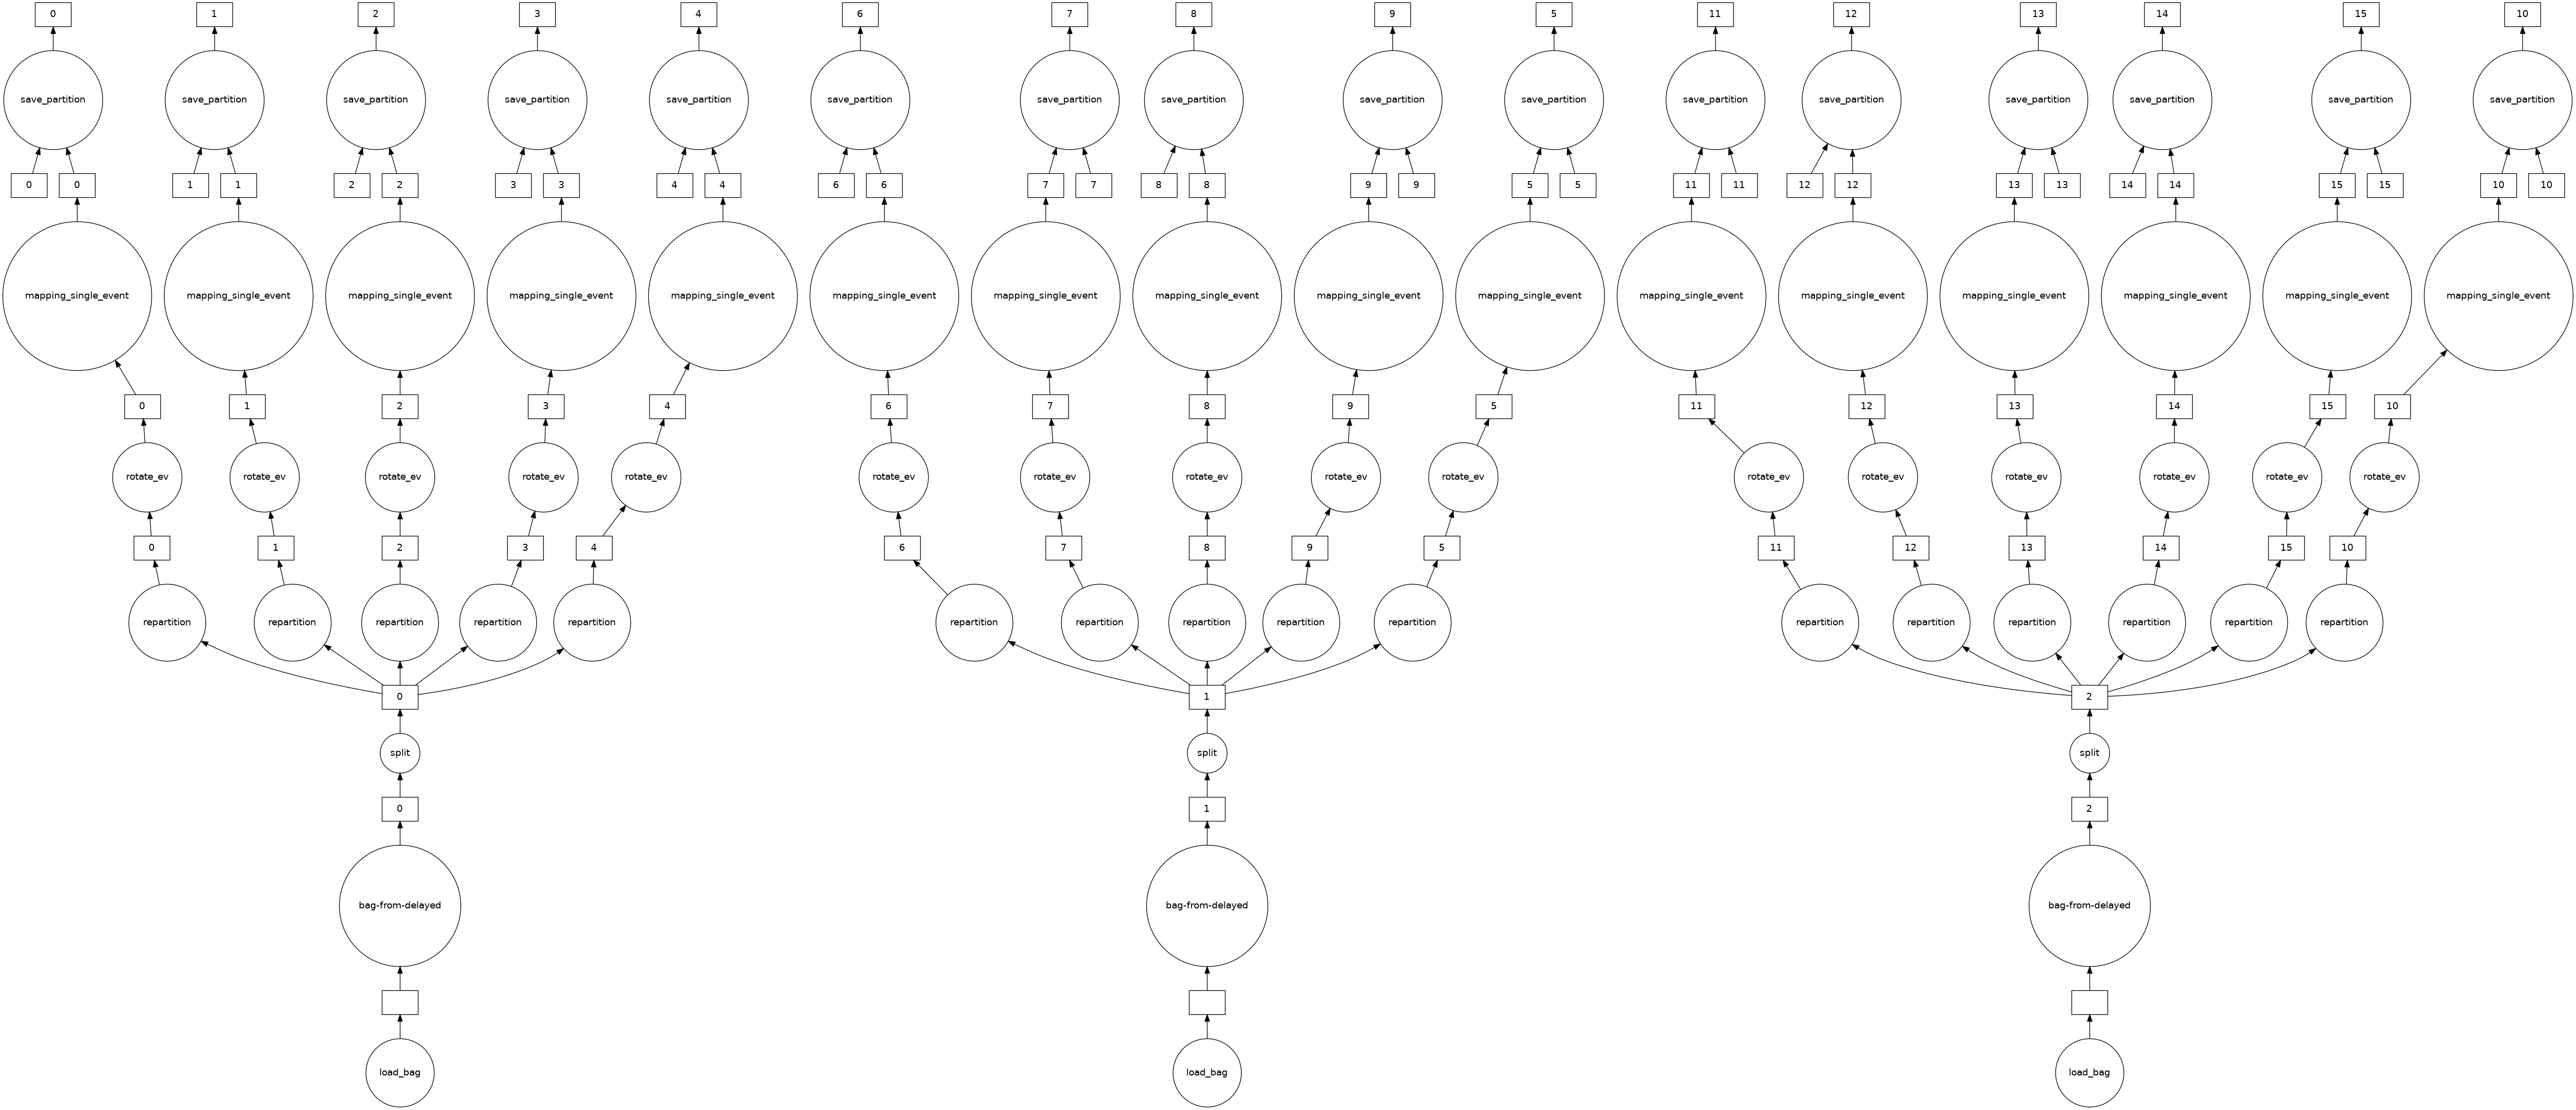

In [110]:
save.visualize(optimize_graph=False)

### Analyze performances

In [152]:
print(f'Compute times\n\tMean:\t{compute_times.mean():.2f} s', 
      f'\n\tstd:\t{compute_times.std():.2f} s', '\n', sep='', end='\n')

print(f'Restart times\n\tMean:\t{restart_times.mean():.2f} s', 
      f'\n\tstd:\t{restart_times.std():.2f} s', '\n', sep='', end='\n')

Compute times
	Mean:	87.51 s
	std:	31.13 s

Restart times
	Mean:	2.58 s
	std:	0.50 s



## Optimize mapping

In [20]:
N_max = 115

def mapping_single_event(rotated_ev):
    ####################
    # rotated_ev must be computed
    ####################
    coord_new   = rotated_ev[:3]
    charge_hitt = rotated_ev[4:, ].T
    R           = rotated_ev[3, ].mean()
    del rotated_ev

    z_levels, step = np.linspace(coord_new[2,].min(), coord_new[2,].max(), 124, retstep=True)
    #z_levels       = z_levels.persist()
    image_mat      = np.zeros((230,124,2))

    masks = (np.abs(coord_new[2,].reshape((1, -1)) - z_levels.reshape((-1,1))) < step/2)
    Rzs = (R**2 - z_levels**2)
    Neff = np.zeros(124)
    Neff[Rzs >=0 ] = N_max * np.sqrt(Rzs[Rzs>=0]) / R

    for j, mask in enumerate(masks):
    
        ix = np.around( Neff[j] * (np.arctan2(coord_new[1,mask], coord_new[0,mask]) / np.pi) + (N_max / 2) ) + 57
        ix = ix.astype(np.int32)
        if(np.any(ix >= 230)):
            ix[ix >= 230] = ix[ix >= 230] - 230

        image_mat[ix, j,] = charge_hitt[mask, ]

        del ix
                

    del z_levels
    del coord_new
    del charge_hitt
    del Neff
    del Rzs
    del masks
    
    return image_mat

## Shutdown cluster

In [139]:
client.shutdown()

In [137]:
client.restart()

<Client: 'tcp://10.67.22.39:38951' processes=6 threads=12, memory=23.31 GiB>